<a href="https://colab.research.google.com/github/funpi89/AI-side-project/blob/master/Brain_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/Healthcare/Brain_MRI

/content/drive/MyDrive/Healthcare/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')
brain_df.head(10)

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0
5  TCGA_CS_5395_19981004  ...    0
6  TCGA_CS_5395_19981004  ...    0
7  TCGA_CS_5395_19981004  ...    0
8  TCGA_CS_5395_19981004  ...    0
9  TCGA_CS_5395_19981004  ...    0

[10 rows x 4 columns]

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

# PERFORM DATA VISUALIZATION

In [ ]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

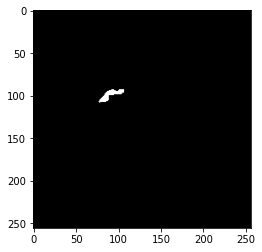

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

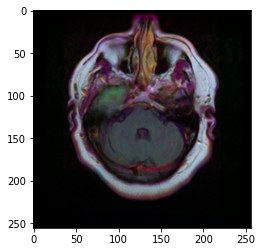

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.image_path[623]).shape

(256, 256, 3)

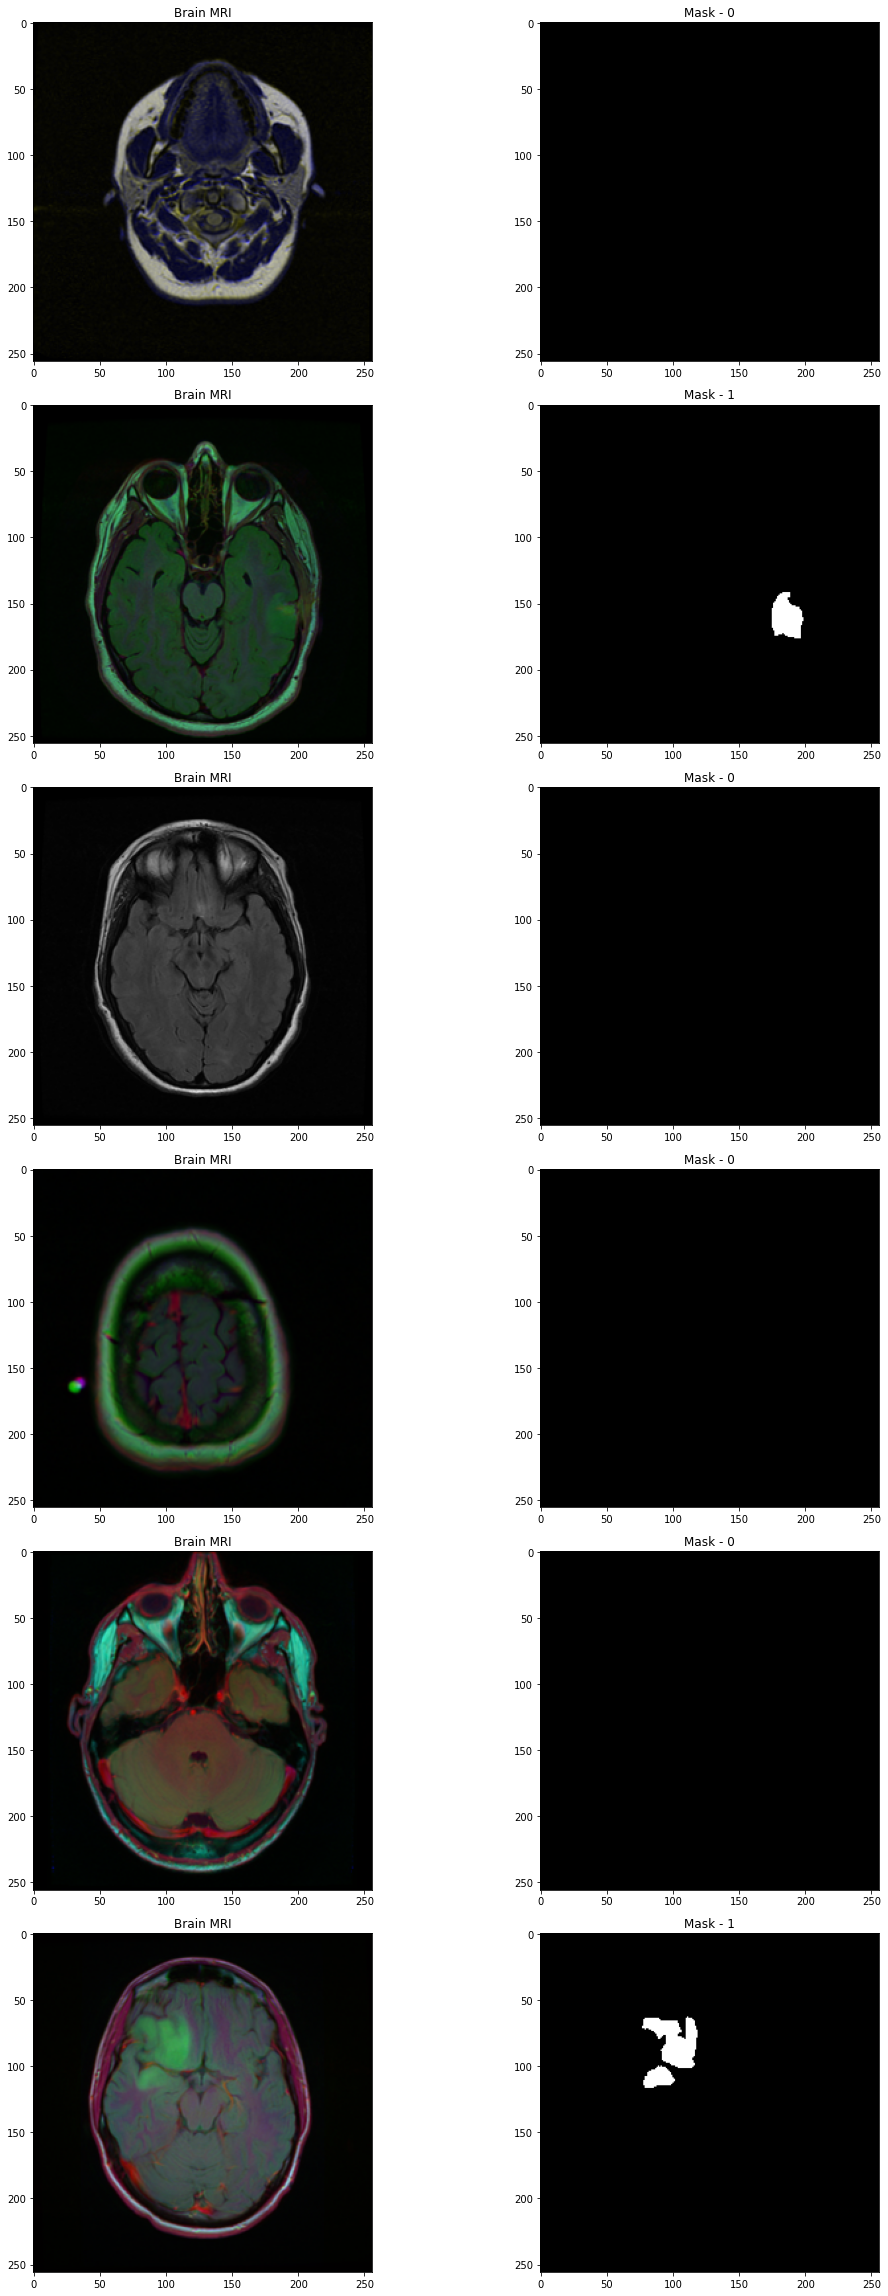

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

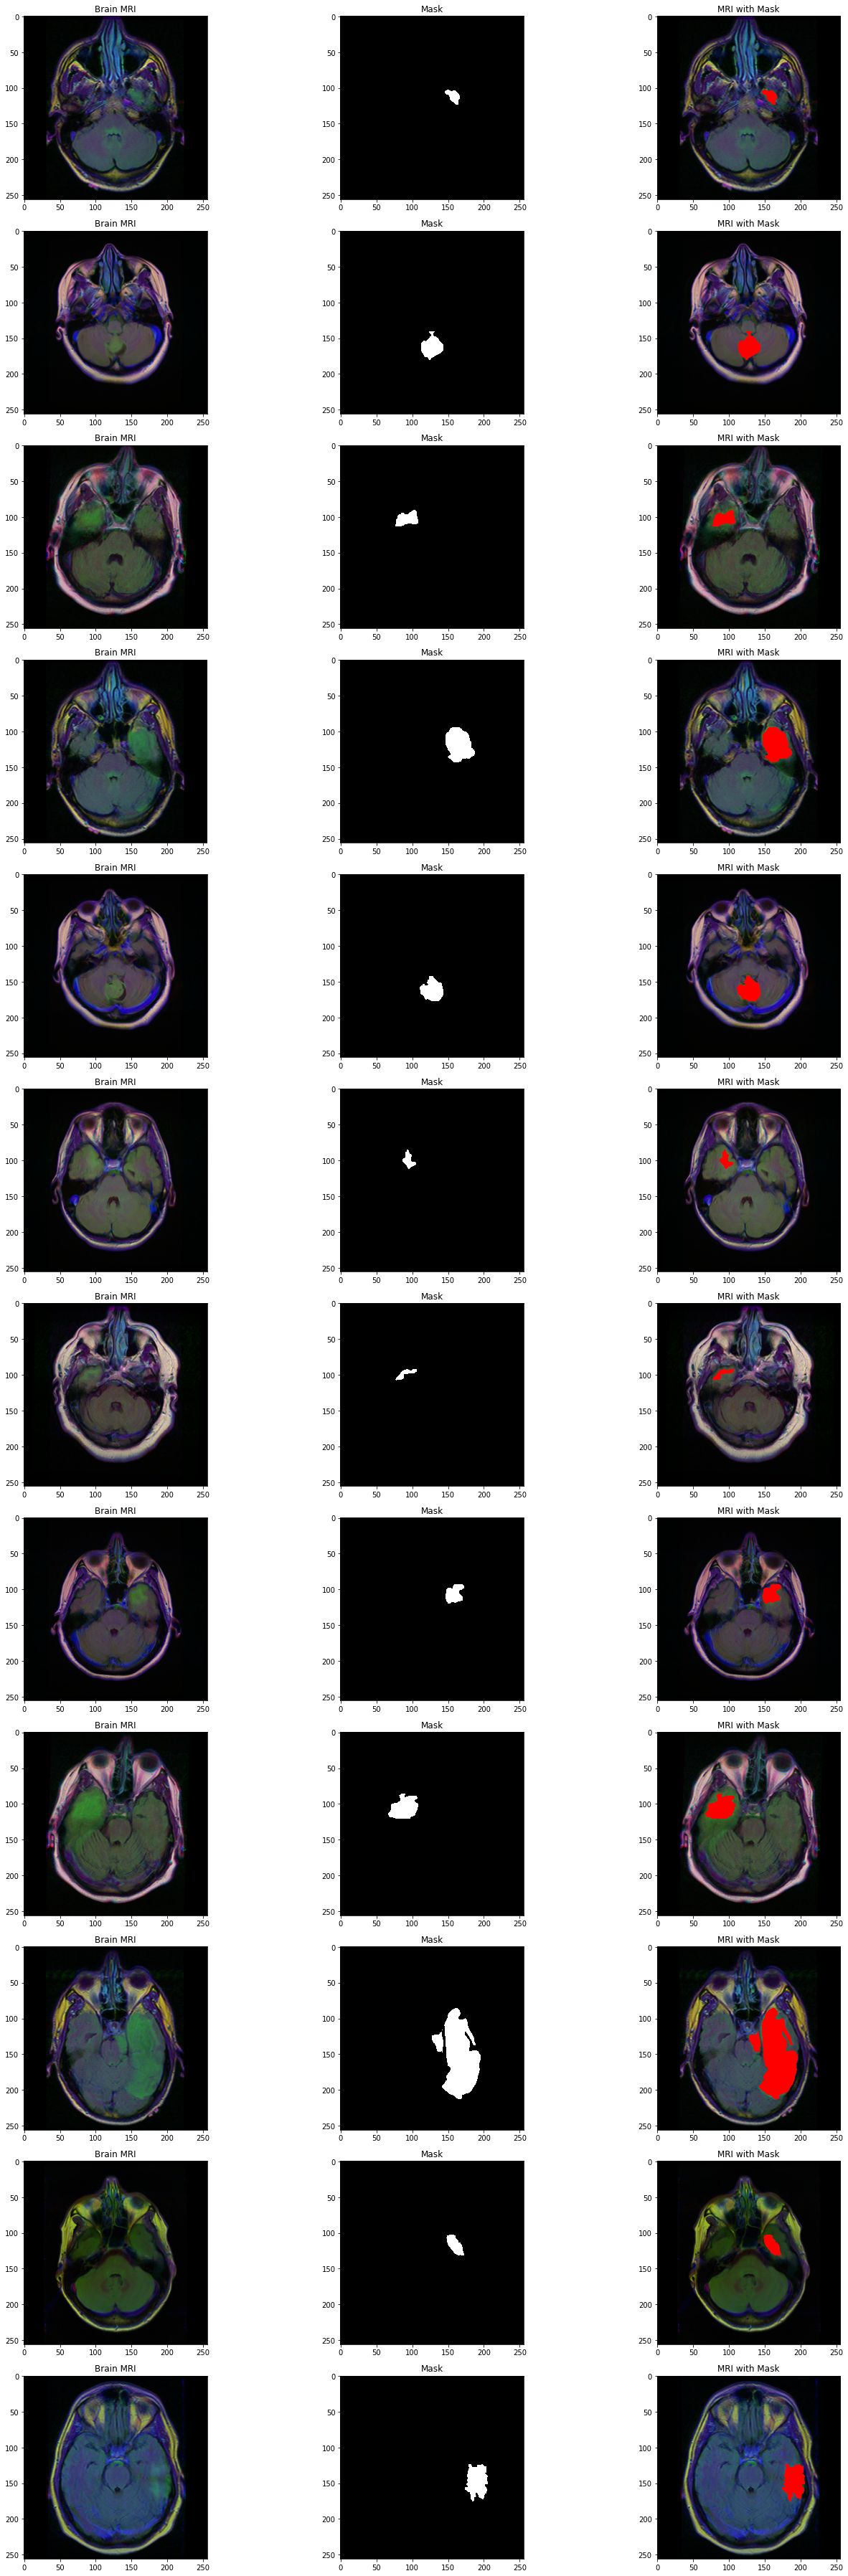

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

# TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
leakyReLU = LeakyReLU()
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dropout(0.1)(headmodel)
headmodel = Dense(256, activation = leakyReLU)(headmodel)
headmodel = BatchNormalization()(headmodel)
headmodel = Dense(64, activation = leakyReLU)(headmodel)
headmodel = BatchNormalization()(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 50, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/50
177/177 [==============================] - 48s 242ms/step - loss: 0.1442 - accuracy: 0.9432 - val_loss: 0.2854 - val_accuracy: 0.9173

Epoch 00001: val_loss improved from inf to 0.28545, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-weights.hdf5
Epoch 2/50
177/177 [==============================] - 41s 234ms/step - loss: 0.0642 - accuracy: 0.9795 - val_loss: 0.2151 - val_accuracy: 0.9536

Epoch 00002: val_loss improved from 0.28545 to 0.21511, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-weights.hdf5
Epoch 3/50
177/177 [==============================] - 42s 235ms/step - loss: 0.0391 - accuracy: 0.9875 - val_loss: 0.1892 - val_accuracy: 0.9435

Epoch 00003: val_loss improved from 0.21511 to 0.18918, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-weights.hdf5
Epoch 4/50
177/177 [==============================] - 42s 234ms/step - loss: 0.0288 - accuracy: 0.9929 - val_loss: 0.3040 - v

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("/content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('/content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel, custom_objects={'LeakyReLU': LeakyReLU})
model.load_weights('/content/drive/MyDrive/Healthcare/Brain_MRI/classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 292s 8s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict

array(['0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1',
       '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0',
       '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0',
       '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1',
       '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0',
       '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9600694444444444

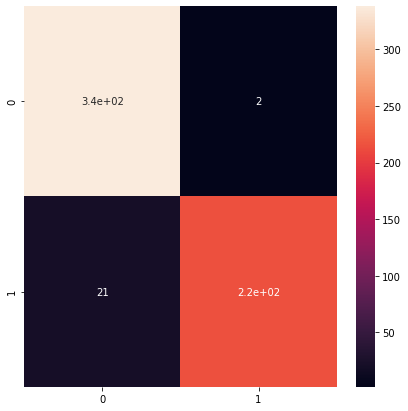

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       340
           1       0.99      0.91      0.95       236

   micro avg       0.96      0.96      0.96       576
   macro avg       0.97      0.95      0.96       576
weighted avg       0.96      0.96      0.96       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

test_ids = list(X_test.image_path)
test_mask= list(X_test.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)
test_generator = DataGenerator(test_ids,test_mask)

In [ ]:
leakyReLU = LeakyReLU()
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = leakyReLU(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = leakyReLU(X)

  return X


In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= leakyReLU, padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= leakyReLU, padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

# TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR

### We need a custom loss function to train this ResUNet.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 50, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/50
72/72 [==============================] - 600s 8s/step - loss: 0.8770 - tversky: 0.1602 - val_loss: 0.7959 - val_tversky: 0.2623

Epoch 00001: val_loss improved from inf to 0.79593, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-weights.hdf5
Epoch 2/50
72/72 [==============================] - 25s 354ms/step - loss: 0.7514 - tversky: 0.3153 - val_loss: 0.7157 - val_tversky: 0.3589

Epoch 00002: val_loss improved from 0.79593 to 0.71572, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-weights.hdf5
Epoch 3/50
72/72 [==============================] - 14s 193ms/step - loss: 0.4564 - tversky: 0.6459 - val_loss: 0.5907 - val_tversky: 0.5031

Epoch 00003: val_loss improved from 0.71572 to 0.59071, saving model to /content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-weights.hdf5
Epoch 4/50
72/72 [==============================] - 14s 191ms/step - loss: 0.3672 - tversky: 0.7349 - val_loss: 0.3793 - val_tversky: 0.7222

Epoch 00004: val_loss impro

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("/content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('/content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel, custom_objects={'LeakyReLU': LeakyReLU})
model_seg.load_weights('/content/drive/MyDrive/Healthcare/Brain_MRI/ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_38...  ...        1
1    TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_20...  ...        0
2    TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_14...  ...        0
3    TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_18...  ...        0
4    TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_19...  ...        0
..                                                 ...  ...      ...
585  TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_11...  ...        0
586  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_48...  ...        0
587  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_34...  ...        0
588  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_2.tif  ...        0
589  TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_17...  ...        1

[590 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_38...  ...        1
1  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_20...  ...        0
2  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_14...  ...        0
3  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_18...  ...        0
4  TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_19...  ...        0

[5 rows x 5 columns]

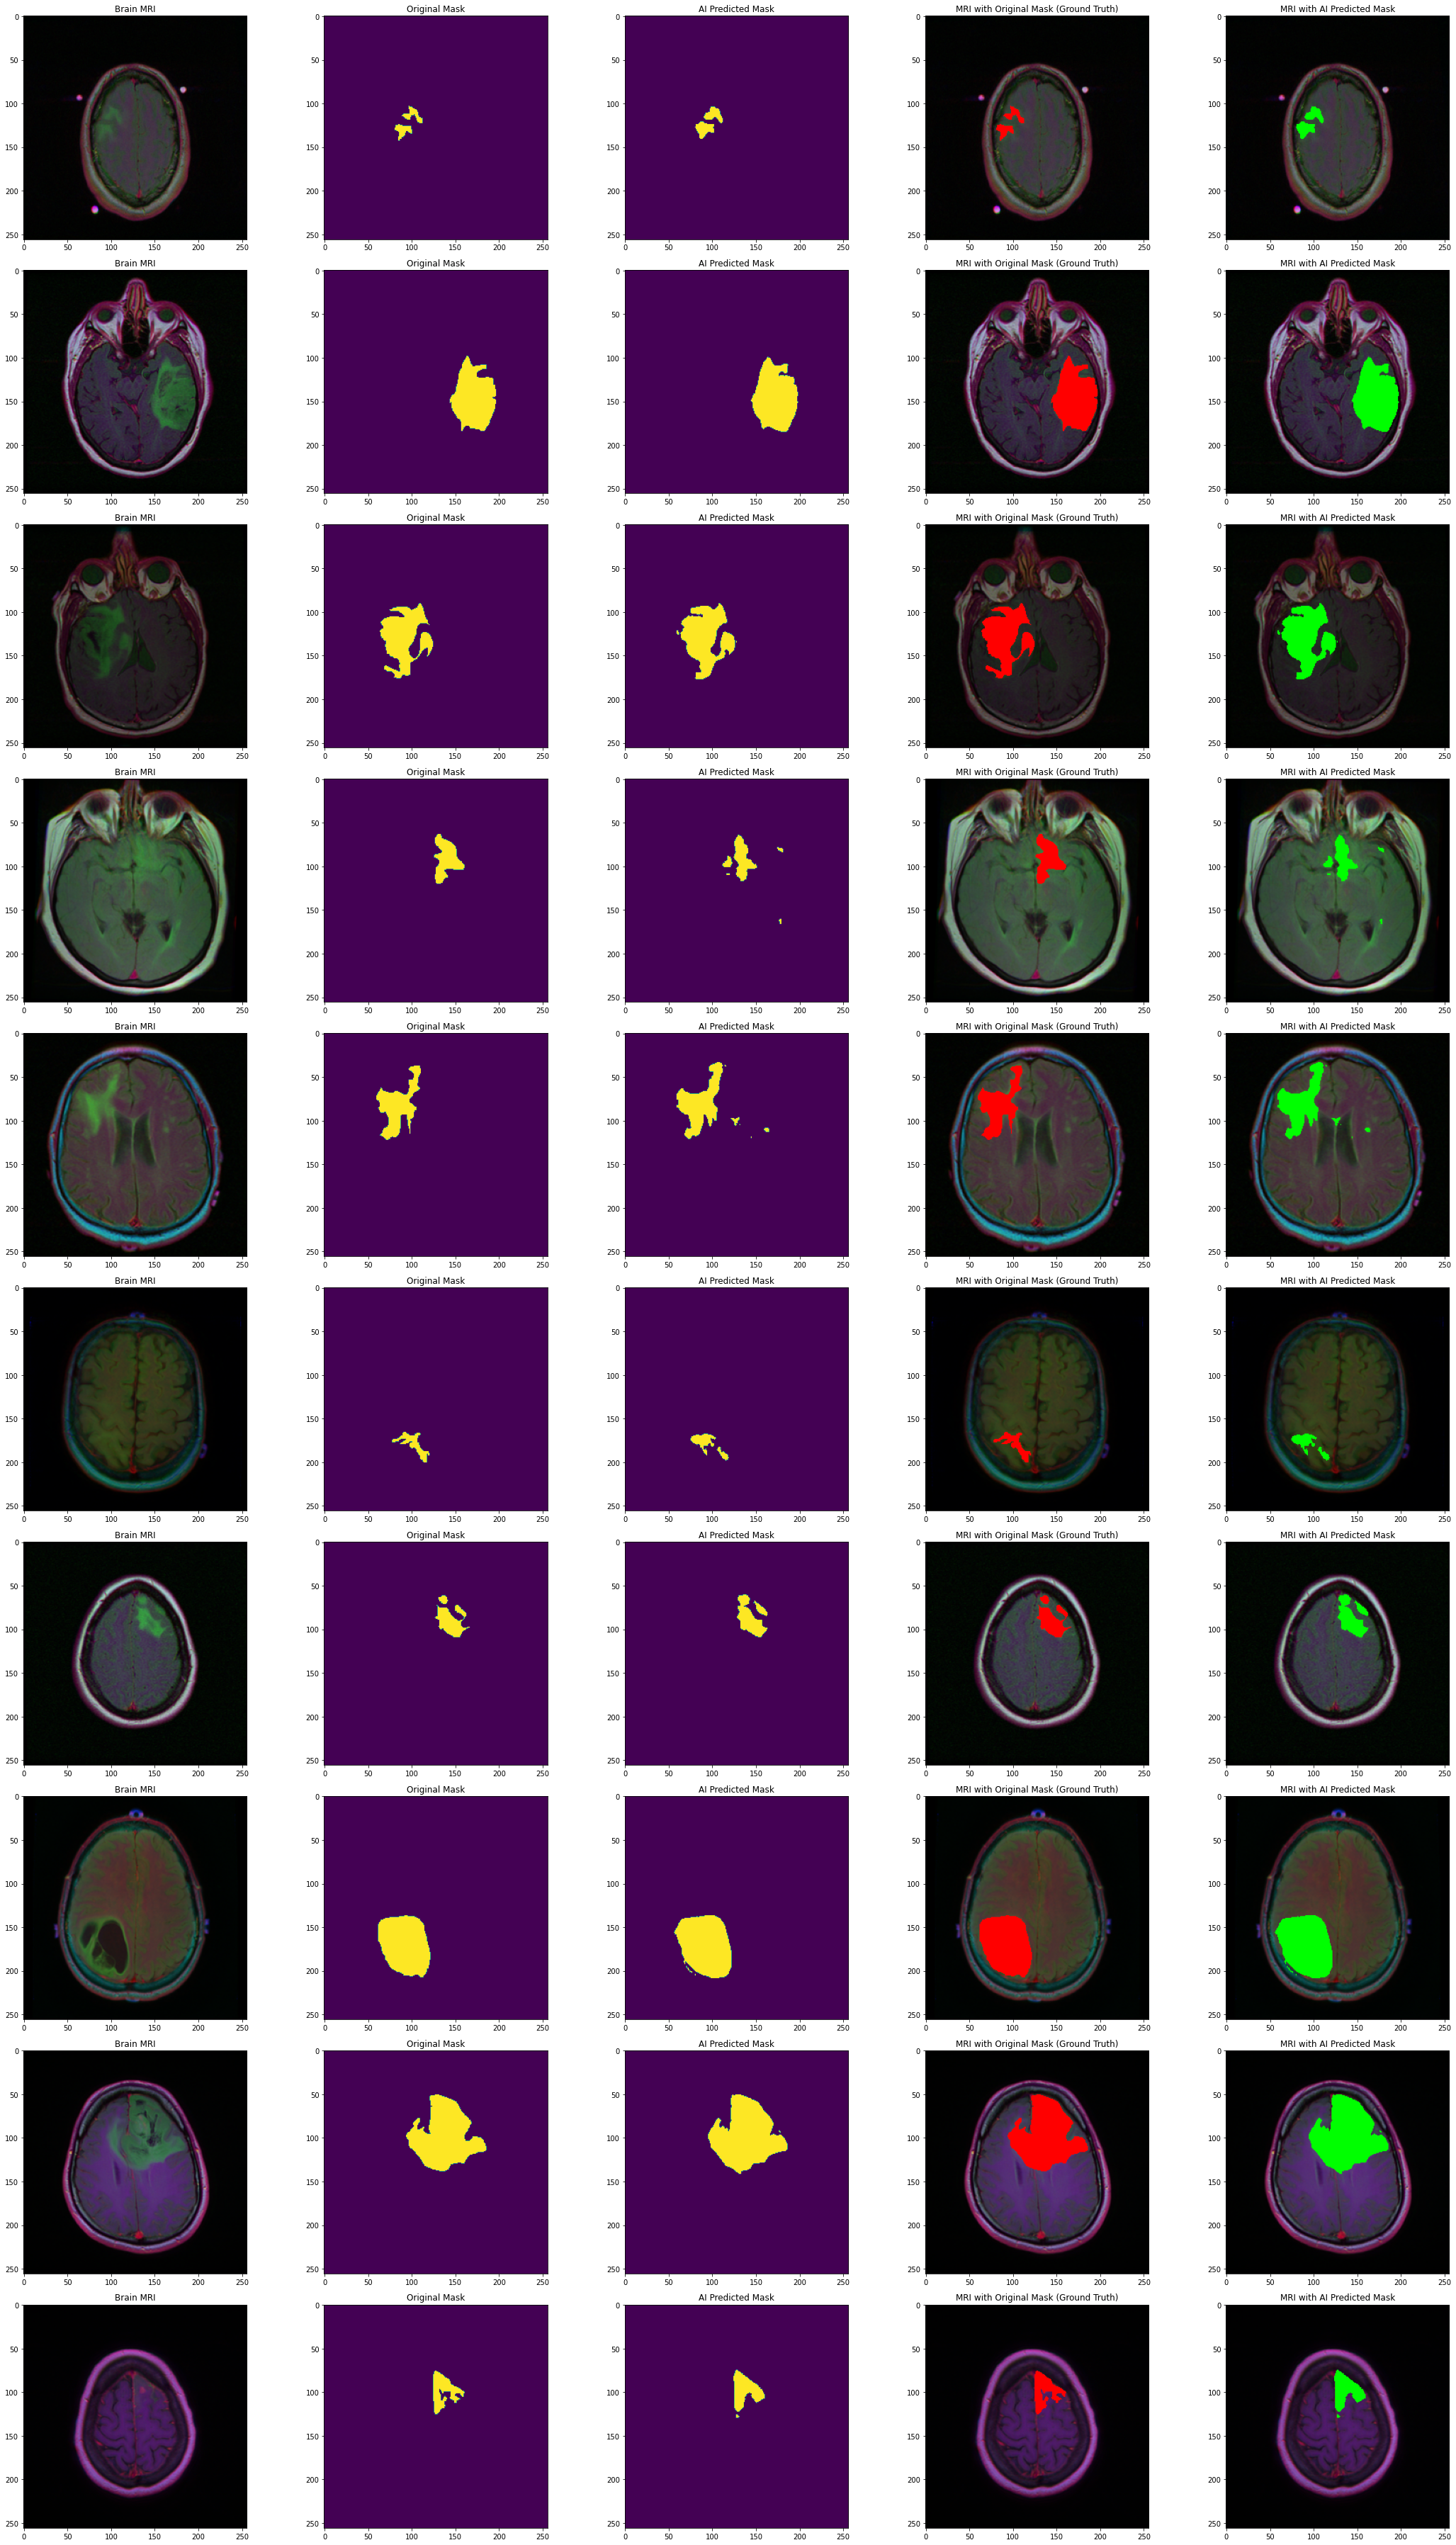

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()